### Packages
***

In [1]:
library(igraph)
library(resample)
library(textTinyR)
library(Matrix)
library(pracma)


載入套件：‘igraph’


下列物件被遮斷自 ‘package:stats’:

    decompose, spectrum


下列物件被遮斷自 ‘package:base’:

    union


載入需要的套件：Matrix


載入套件：‘pracma’


下列物件被遮斷自 ‘package:Matrix’:

    expm, lu, tril, triu




### 3. PageRank: The PageRank algorithm, as used by the Google search engine, exploits the linkage structure of the web to compute global “importance” scores that can be used to influence the ranking of search results. Here, we use random walk to simulate PageRank.
***

#### (a) We are going to create a directed random network with 900 nodes, using the preferential attachment model. Note that in a directed preferential attachment network, the out-degree of every node is m, while the in-degrees follow a power law distribution. One problem of performing random walk in such a network is that, the very first node will have no outbounding edges, and be a “black hole” which a random walker can never “escape” from. To address that, let’s generate another 900-node random network with preferential attachment model, and merge the two networks by adding the edges of the second graph to the first graph with a shuffling of the indices of the nodes. See below figure for example. Create such a network using m = 4. Measure the probability that the walker visits each node. Is this probability related to the degree of the nodes?

<img src="f1.png" width="500">

> Ans: 
The code output provides the probability of the random walker visiting each node, and goes a step further to give an idea of the probability of visiting nodes with a given degree. The Pearson correlation coefficient for this relationship is 0.931533, and a linear regression analysis reveals a slope of 0.0001598. The high Pearson coefficient indicates an approximately proportional relationship, which is reasonable since a node with a higher in-degree should have a higher probability of being visited by the random walker.

In [66]:
# Create the transition matrix for random walk given a graph
create_transition_matrix <- function (g) {
  n <- vcount(g)
  adj <- as_adjacency_matrix(g)
  adj[diag(rowSums(adj) == 0)] <- 1  # Replace diagonal elements with 1 for nodes with no outgoing edges
  row_sums <- rowSums(adj)
  transition_matrix <- sweep(adj, 1, row_sums, "/") # Divide each row of adjacency matrix by row sums
  return(transition_matrix)
}

In [70]:
# Perform a random walk with optional teleportation, given a graph, number of steps, and starting node
random_walk_custom <- function(g, num_steps, start_node, transition_matrix = NULL, alpha = 0.0, visit_mode = "equal") {
  if (is.null(transition_matrix)) {
    transition_matrix <- create_transition_matrix(g) # If transition_matrix is not provided, create it
  }
  
  curr_node <- start_node
  walked_nodes <- numeric(num_steps) # Initialize a vector to store the visited nodes in the random walk
  visit_probs <- get_visit_probs(g, visit_mode) # Get visit probabilities based on the visit_mode

  for (i in seq_len(num_steps)) {
    if (runif(1) < alpha) { # Teleport with probability alpha
      curr_node <- sample(1:vcount(g), 1, prob = visit_probs)
    } else { # Move to one of the neighbors
      neighbors <- igraph::neighbors(g, curr_node, mode = "out")
      curr_node <- if (length(neighbors) == 0) sample(1:vcount(g), 1, prob = visit_probs) else sample(neighbors, 1)
    }
    walked_nodes[i] <- curr_node
  }
  
  return(walked_nodes)
}

In [71]:
# Get visit probabilities based on visit_mode
get_visit_probs <- function(g, visit_mode) {
  n <- vcount(g)
  switch(visit_mode,
         equal = rep(1/n, n), # Equal probability for all nodes
         page_rank = { # Probabilities proportional to PageRank values
           pr <- page_rank(g, directed = TRUE)$vector
           pr / sum(pr)
         },
         page_rank_median = { # 0.5 probability for nodes with median PageRank values
           pr <- page_rank(g, directed = TRUE)$vector
           df <- data.frame("idx" = 1:n, "val" = pr)
           df <- df[order(df$val),]
           visit_probs <- numeric(n)
           visit_probs[df$idx[(n %/% 2):(n %/% 2) + 1]] <- 0.5
           visit_probs
         },
         rep(1/n, n) # Default to equal probability for all nodes
  )
}

In [72]:
# Generate two Barabasi-Albert graphs and merge them
g1 <- barabasi.game(900, m = 4, directed = TRUE)
g2 <- barabasi.game(900, m = 4, directed = TRUE)
gf <- add_edges(g1, c(t(as_edgelist(permute(g2, sample(vcount(g2)))))))

In [73]:
# Set the number of random walk steps and experimental trials
num_steps <- 1000
num_trials <- 100

# Calculate the position of the stable node, which is the initial few steps that are not counted in the visit count
stable_node <- ceiling(log(vcount(gf)))

# Initialize the visit count for each node
visited_nodes <- numeric(vcount(gf))

# Perform num_trials random walks, starting from a random node each time, and calculate the visit count for each node
for (trial in seq_len(num_trials)) {
  start_node <- sample(1:vcount(gf), 1)
  walked_nodes <- random_walk_custom(g = gf, num_steps = num_steps, start_node = start_node, visit_mode = 'equal')
  for (step in (stable_node + 1):length(walked_nodes)) {
    visited_nodes[walked_nodes[step]] <- visited_nodes[walked_nodes[step]] + 1
  }
}

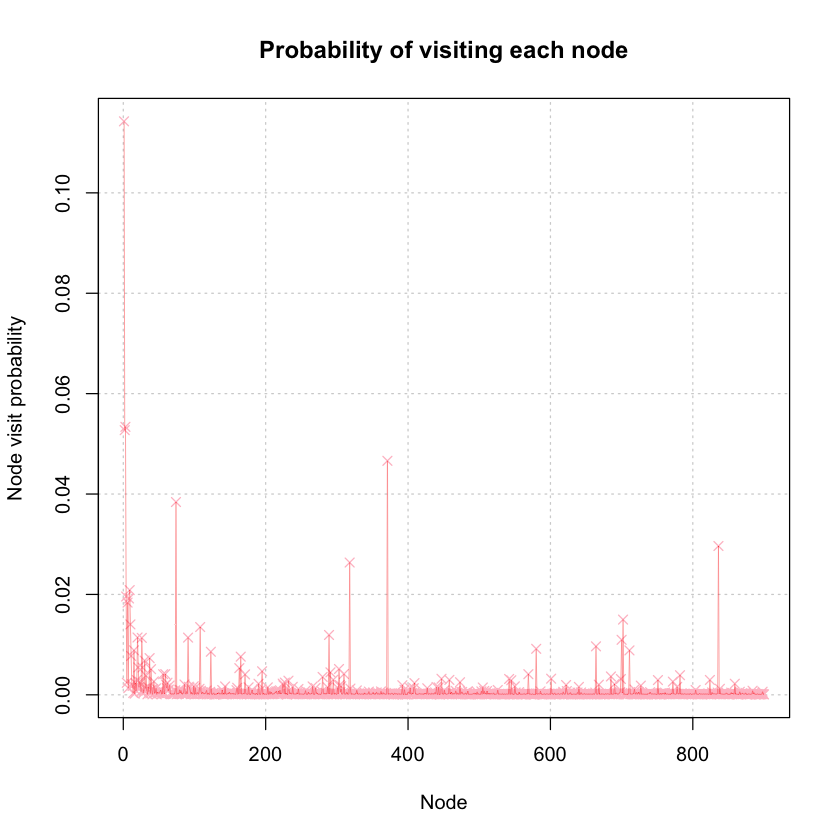

In [75]:
# Calculate the visit probability for each node
node_prob <- visited_nodes / ((num_steps - stable_node) * num_trials)

# Plot the visit probability of each node, with the x-axis representing the node index and the y-axis representing the visit probability
plot(seq(1, 900, 1), node_prob, pch = 4, xlab = 'Node', ylab = 'Node visit probability',
     main = 'Probability of visiting each node', col = 'pink', grid())
lines(node_prob, lwd = 0.3, col = "red")

Pearson correlation coefficient: 0.931533
Slope and intercept:



Call:
lm(formula = node_prob ~ node_degree)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0184111 -0.0001581  0.0001414  0.0002713  0.0201300 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.439e-03  7.418e-05  -19.39   <2e-16 ***
node_degree  1.598e-04  2.082e-06   76.76   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.00199 on 898 degrees of freedom
Multiple R-squared:  0.8678,	Adjusted R-squared:  0.8676 
F-statistic:  5892 on 1 and 898 DF,  p-value: < 2.2e-16


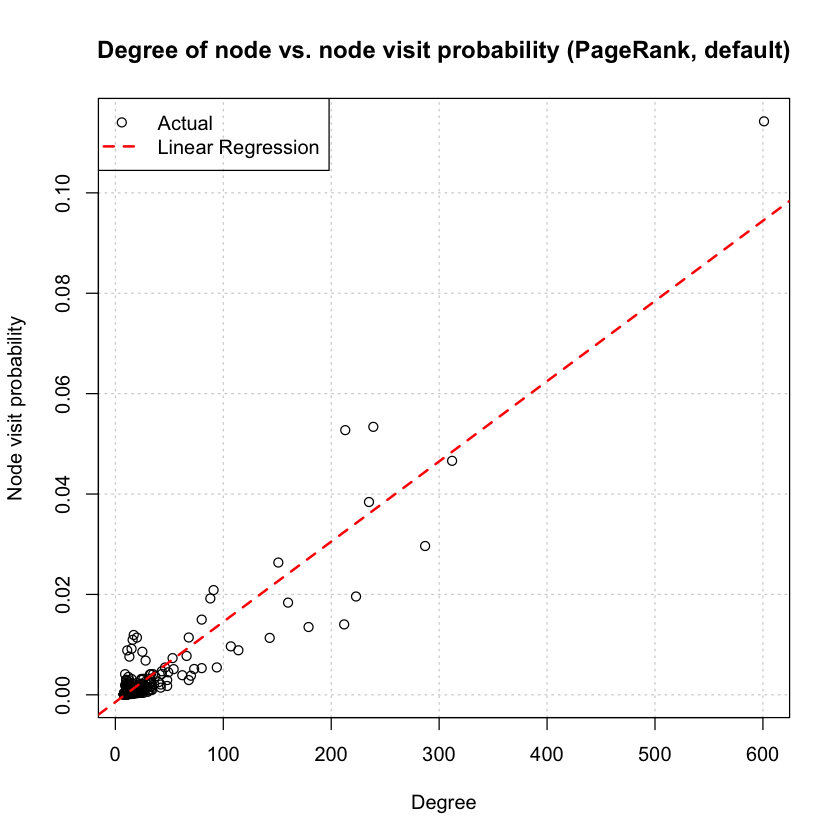

In [76]:
# Calculate the visit probability for each node as before
node_prob <- visited_nodes / ((num_steps - stable_node) * num_trials)

# Calculate the degree of each node in the graph
node_degree <- degree(gf)

# Plot the node visit probability as a function of node degree, and add a linear regression line
plot(node_degree, node_prob, xlab = 'Degree', ylab = 'Node visit probability', 
     main = "Degree of node vs. node visit probability (PageRank, default)", grid())
abline(lm(node_prob ~ node_degree), col = "red", lwd = 2, lty = 2)

# Add a legend to the plot
legend('topleft', legend = c("Actual", "Linear Regression"),
       lty = c(NA, 2), lwd = c(1, 2), pch = c(1, NA), col = c('black', 'red'))

# Print the Pearson correlation coefficient between node degree and visit probability, and the slope and intercept of the linear regression
cat(sprintf("Pearson correlation coefficient: %f\n", cor(node_degree, node_prob)))
cat("Slope and intercept:\n")
summary(lm(node_prob ~ node_degree))


#### (b) In all previous questions, we didn’t have any teleportation. Now, we use a teleportation probability of α = 0.2 (teleport out of a node with prob=0.2 instead of going to its neighbor). By performing random walks on the network created in 3(a), measure the probability that the walker visits each node. How is this probability related to the degree of the node and α ?

> Ans: 
In this case, the experiment is conducted similarly to the one in section 2.3(a), with the addition of the ability for the random walk to teleport. At each step, the random walker has the option to either visit one of its neighbors with probability (1 − α) or to teleport with probability α, randomly selecting the next node. The resulting probability that the random walker visits each node gives the probability that the random walker visits nodes with a given degree. The Pearson correlation coefficient of this relationship is 0.954783, and the linear fit gives a slope of 0.0001257. The relatively lower slope compared to section 2.3(a) is consistent with the observation that the probability of visitation for nodes with higher degrees has decreased comparatively in section 2.3(b). This is the trade-off caused by teleportation, resulting in higher probabilities for lower-degree nodes to be visited.

In [81]:
# Set the number of random walk steps and initialize the visit count for each node
num_steps <- 1000
node_visit_count <- numeric(vcount(gf))

# Calculate the position of the stable node, which is the initial few steps that are not counted in the visit count
stable_node <- ceiling(log(vcount(gf)))

# Perform a set of random walks and count the number of visits to each node
for (trial in 1:100) {
  start_node <- sample(1:vcount(gf), 1)
  walked_nodes <- random_walk_custom(g = gf, num_steps = num_steps, start_node = start_node, alpha = 0.2, visit_mode = 'equal')
  for (step in (stable_node + 1):length(walked_nodes)) {
    node_visit_count[walked_nodes[step]] <- node_visit_count[walked_nodes[step]] + 1
  }
}

# Calculate the visit probability for each node
node_prob <- node_visit_count / ((num_steps - stable_node) * 100)


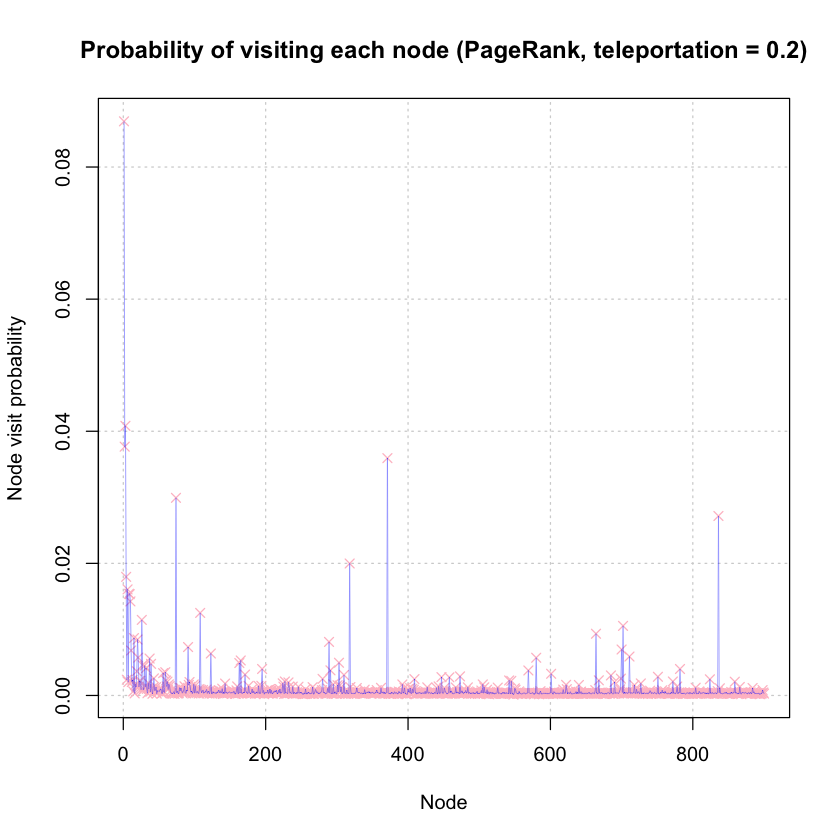

In [82]:
# Create a sequence of numbers from 1 to the number of nodes in the graph
node_indices <- seq_len(vcount(gf))

# Plot the visit probability for each node as a scatter plot with pink dots
plot(node_indices, node_prob, pch = 4, xlab = 'Node', ylab = 'Node visit probability',
     main = 'Probability of visiting each node (PageRank, teleportation = 0.2)', col = 'pink', grid())

# Add a line connecting the plotted points with a blue color and a line width of 0.3
lines(node_indices, node_prob, lwd = 0.3, col = 'blue')

Pearson correlation coefficient: 0.954783
Slope and intercept:



Call:
lm(formula = node_prob ~ degree(gf))

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0115056 -0.0001071  0.0000852  0.0001806  0.0122930 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.938e-04  4.652e-05  -19.21   <2e-16 ***
degree(gf)   1.257e-04  1.306e-06   96.24   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.001248 on 898 degrees of freedom
Multiple R-squared:  0.9116,	Adjusted R-squared:  0.9115 
F-statistic:  9262 on 1 and 898 DF,  p-value: < 2.2e-16


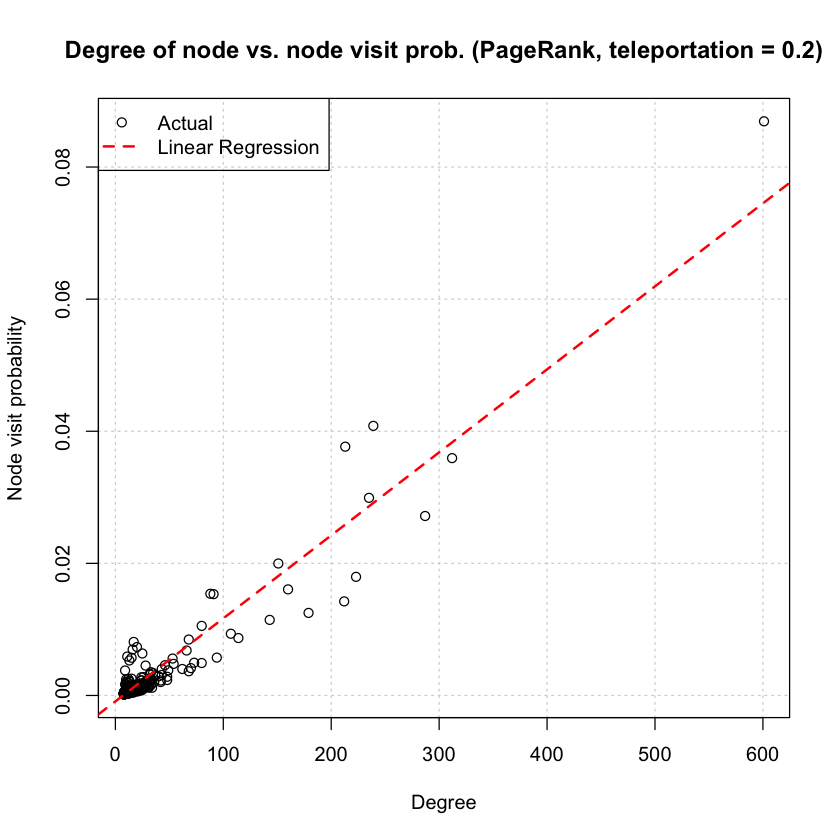

In [85]:
# Plot the visit probability as a function of node degree
plot(degree(gf), node_prob, xlab = 'Degree', ylab = 'Node visit probability',
     main = "Degree of node vs. node visit prob. (PageRank, teleportation = 0.2)", grid())

# Add a red dashed line representing the linear regression fit
abline(lm(node_prob ~ degree(gf)), col = "red", lwd = 2, lty = 2)

# Add a legend indicating the actual data and the linear regression line
legend('topleft', legend = c("Actual", "Linear Regression"),
       lty = c(NA, 2), lwd = c(1, 2), pch = c(1, NA),
       col = c('black', 'red'))

# Print the Pearson correlation coefficient and the slope and intercept of the linear regression
cat(sprintf("Pearson correlation coefficient: %f\n", cor(degree(gf), node_prob)))
cat("Slope and intercept:\n")
summary(lm(node_prob ~ degree(gf)))


### 4. Personalized PageRank: While the use of PageRank has proven very effective, the web’s rapid growth in size and diversity drives an increasing demand for greater flexibility in ranking. Ideally, each user should be able to define their own notion of importance for each individual query.
***

#### (a) Suppose you have your own notion of importance. Your interest in a node is proportional to the node’s PageRank, because you totally rely upon Google to decide which website to visit (assume that these nodes represent websites). Again, use random walk on network generated in question 3 to simulate this personalized PageRank. Here the teleportation probability to each node is proportional to its PageRank (as opposed to the regular PageRank, where at teleportation, the chance of visiting all nodes are the same and equal to 1/N ). Again, let the teleportation probability be equal to α = 0.2. Compare the results with 3(a).

> Ans: 

#### (b) Find two nodes in the network with median PageRanks. Repeat part 4(a) if teleportations land only on those two nodes (with probabilities 1/2, 1/2). How are the PageRank values affected?

> Ans: 

#### (c) More or less, 4(b) is what happens in the real world, in that a user browsing the web only teleports to a set of trusted web pages. However, this is against the assumption of normal PageRank, where we assume that people’s interest in all nodes are the same. Can you take into account the effect of this self-reinforcement and adjust the PageRank equation?

> Ans: 